# Part 1 — Logistic Regression Introduction

# Logistic Regression

### **Supervised Learning — Binary Classification**

### _Industrial Engineering Application: Quality Prediction in Mineral Processing_

Logistic Regression is a fundamental supervised learning algorithm used for **binary classification**.  
Unlike linear regression, which predicts continuous outcomes, logistic regression predicts the **probability** that an input sample belongs to a particular class.

##  1. The Logistic (Sigmoid) Function

Given a linear model:

$$\large z = \mathbf{w}^\top \mathbf{x} + b$$

Logistic regression applies the **sigmoid transformation**:

$$
\large \sigma(z) = \frac{1}{1 + e^{-z}}
$$​

This maps any real-valued number into **(0, 1)**, making it interpretable as:

$$\large P(y=1 \mid x)$$

## 2. Odds and Log-Odds

The output probability describes the _odds_:

$$\large \text{odds} = \frac{P(y=1)}{1 - P(y=1)}$$

Taking the natural logarithm:

$$\large \log \frac{P(y=1)}{1 - P(y=1)} = \mathbf{w}^\top \mathbf{x} + b$$

This means logistic regression is performing **linear modeling in the log-odds space**.

## 3. Loss Function — Binary Cross Entropy

For binary labels y∈{0,1}y \in \{0, 1\}y∈{0,1}, the logistic regression minimizes:

$$\large \mathcal{L} = - \left[ y \log(\hat{y}) + (1 - y) \log(1 - \hat{y}) \right]$$

where $$\large \hat{y} = \sigma(\mathbf{w}^\top \mathbf{x} + b)$$

## 4. Gradient Descent Update Rules

Given the error:

$$\large e = \hat{y} - y$$

The gradients become:

$$\large \frac{\partial \mathcal{L}}{\partial \mathbf{w}} = e \mathbf{x}$$
$$\large \frac{\partial \mathcal{L}}{\partial b} = e$$

Thus, weight updates follow:

$$\large \mathbf{w} \leftarrow \mathbf{w} - \eta \frac{\partial \mathcal{L}}{\partial \mathbf{w}}$$
$$\large b \leftarrow b - \eta \frac{\partial \mathcal{L}}{\partial b}$$

##  5. Why Logistic Regression in Industrial Engineering?

Industrial engineering systems frequently involve **pass/fail**, **spec-in/spec-out**, or **acceptable/unacceptable** outcomes.

Examples include:

- Quality classification in a manufacturing line
    
- Predicting whether a product meets chemical or physical specifications
    
- Equipment fault detection
    
- Safety incident prediction
    
- Supplier performance (on-time vs delayed)
    

###  In this notebook

We apply logistic regression to predict **whether the % Silica in mineral concentrate exceeds a specification limit** — a critical task in mineral processing quality control.

# Part 2 - dataset and introduction

##  1. Data Introduction — Mineral Flotation Process

This dataset comes from a real-world mineral flotation plant.  
The goal is to **predict the % of Silica in the final iron ore concentrate**, which represents impurity level.

High silica content → **poor-quality concentrate**  
Low silica content → **high-quality product**

In this notebook, we convert this continuous measurement into a **binary quality label** suitable for logistic regression.

The dataset contains:

- Physical & chemical parameters
    
- Sensor readings (pH, flow, levels, pressures)
    
- Operational parameters (reagent dose, air flow, froth level)
    

These variables represent typical process engineering features found in IE and chemical engineering systems.

In [29]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option("display.max_columns", 100)

# Load dataset
df = pd.read_csv("D:\\研究生\\机器学习\\INDE-577\\ml_project\\examples\\data\\Mining_small.csv")

# Step 0 — Fix numeric formatting issues BEFORE creating df_clean
# Replace comma decimal format: "56,65" -> "56.65"
df = df.applymap(lambda x: str(x).replace(",", ".") if isinstance(x, str) else x)

# Convert numeric-looking strings to float
for col in df.columns:
    df[col] = pd.to_numeric(df[col], errors="ignore")

# Check types and preview
print(df.dtypes)
df.head()


% Iron Feed                     float64
% Silica Feed                   float64
Starch Flow                     float64
Amina Flow                      float64
Ore Pulp Flow                   float64
Ore Pulp pH                     float64
Ore Pulp Density                float64
Flotation Column 01 Air Flow    float64
Flotation Column 02 Air Flow    float64
Flotation Column 03 Air Flow    float64
% Silica Concentrate            float64
dtype: object


C:\Users\Lenovo\AppData\Local\Temp\ipykernel_220636\3781968238.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(lambda x: str(x).replace(",", ".") if isinstance(x, str) else x)
C:\Users\Lenovo\AppData\Local\Temp\ipykernel_220636\3781968238.py:17: FutureWarning: errors='ignore' is deprecated and will raise in a future version. Use to_numeric without passing `errors` and catch exceptions explicitly instead
  df[col] = pd.to_numeric(df[col], errors="ignore")


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,% Silica Concentrate
0,56.65,14.83,2969.800000,474.569,397.08500,9.62077,1.71086,249.935,250.636,248.950,3.54
1,60.24,8.87,3751.370000,552.399,405.80600,9.22732,1.76000,250.697,255.399,251.949,1.30
2,60.24,8.87,3770.700000,518.311,401.49900,9.26991,1.75000,250.455,251.752,251.873,2.08
3,48.81,25.31,3633.310000,335.078,378.75031,10.10850,1.67378,299.487,254.001,302.563,1.45
4,59.89,8.98,794.536195,561.523,400.66400,9.39431,1.76000,248.236,249.983,251.840,2.97


## 2. Data Cleaning
------------------------------------------------
Before building a logistic regression model, it is necessary to clean and prepare the dataset to ensure that the input features are meaningful and consistent. The flotation process data contains measurements from different sensors and process stages, and not all variables are complete or equally reliable. Some data points may include missing values due to sensor downtime, communication delays, or intermittent failures in the process monitoring system.

The first step is to identify and handle missing values. Columns with a large proportion of missing entries may not provide useful information and can be removed from the dataset. For columns with only a small number of missing values, it is common practice to apply simple imputation, such as replacing missing entries with the column mean or median. This ensures that all samples have valid feature values and prevents errors during model training.

Next, numerical variables may need to be inspected for unreasonable values, such as negative flows or pressures, which cannot occur physically. If such values exist, they should either be corrected based on engineering knowledge or removed from the dataset.

After addressing missing and invalid values, the dataset is checked for variables that have little or no variation across all samples. Features that remain nearly constant do not contribute to classification and can be removed to simplify the model. Highly correlated features may also be examined to avoid redundancy, although logistic regression can still handle them without major issues.

By performing these steps, the dataset is transformed into a clean and consistent set of input variables that can be used effectively for logistic regression modeling. This preparation ensures that the model reflects meaningful physical relationships in the flotation process rather than noise or measurement anomalies.


In [30]:
# Part 2 — Data Cleaning

df_clean = df.copy()   # ← NOW df is clean, so df_clean will be clean too

# 1. Missing values per column
missing_summary = df_clean.isnull().sum().sort_values(ascending=False)
print("Missing values per column:")
print(missing_summary)

# 2. Remove columns with too many missing values (>40%)
threshold = 0.40
cols_to_drop = missing_summary[missing_summary > threshold * len(df_clean)].index.tolist()
print("\nColumns dropped due to excessive missing values:", cols_to_drop)

df_clean = df_clean.drop(columns=cols_to_drop)

# 3. Impute missing values using column mean
df_clean = df_clean.fillna(df_clean.mean(numeric_only=True))

# 4. Remove low-variance columns (std < 1e-6)
low_variance_cols = [col for col in df_clean.columns if df_clean[col].std() < 1e-6]
print("\nLow-variance columns removed:", low_variance_cols)

df_clean = df_clean.drop(columns=low_variance_cols)

# 5. Confirm no missing values remain
print("\nRemaining missing values:", df_clean.isnull().sum().sum())

df_clean.head()


Missing values per column:
% Iron Feed                     0
% Silica Feed                   0
Starch Flow                     0
Amina Flow                      0
Ore Pulp Flow                   0
Ore Pulp pH                     0
Ore Pulp Density                0
Flotation Column 01 Air Flow    0
Flotation Column 02 Air Flow    0
Flotation Column 03 Air Flow    0
% Silica Concentrate            0
dtype: int64

Columns dropped due to excessive missing values: []

Low-variance columns removed: []

Remaining missing values: 0


,% Iron Feed,% Silica Feed,Starch Flow,Amina Flow,Ore Pulp Flow,Ore Pulp pH,Ore Pulp Density,Flotation Column 01 Air Flow,Flotation Column 02 Air Flow,Flotation Column 03 Air Flow,% Silica Concentrate
0,56.65,14.83,2969.800000,474.569,397.08500,9.62077,1.71086,249.935,250.636,248.950,3.54
1,60.24,8.87,3751.370000,552.399,405.80600,9.22732,1.76000,250.697,255.399,251.949,1.30
2,60.24,8.87,3770.700000,518.311,401.49900,9.26991,1.75000,250.455,251.752,251.873,2.08
3,48.81,25.31,3633.310000,335.078,378.75031,10.10850,1.67378,299.487,254.001,302.563,1.45
4,59.89,8.98,794.536195,561.523,400.66400,9.39431,1.76000,248.236,249.983,251.840,2.97


## 3. Constructing the Quality Label
------------------------------------------------
The variable % Silica Concentrate represents the percentage of silica in the final product of the flotation process. Since silica acts as an impurity, the quality of the concentrate is evaluated by comparing this measurement against a specification limit. In industrial practice, a threshold value of 2.0 percent silica is commonly used to distinguish acceptable material from out-of-specification material.

To prepare the data for logistic regression, the continuous % Silica Concentrate variable is converted into a binary quality label. Samples with silica content less than or equal to 2.0 percent are assigned a label of 0, indicating acceptable product quality. Samples with silica content greater than 2.0 percent are assigned a label of 1, indicating poor quality or failure to meet specifications.

This binary transformation aligns the modeling objective with typical decision-making in process and quality engineering, where the key question is whether the product meets established specifications. Once the label is created, it will serve as the target variable for the logistic regression model.


In [31]:
# Part 3 — Constructing the Quality Label

df_model = df_clean.copy()

# Target column
target_col = "% Silica Concentrate"

# Construct binary quality label using 2.0% threshold
df_model["Quality_Label"] = (df_model[target_col] > 2.0).astype(int)

# Check distribution of quality labels
df_model["Quality_Label"].value_counts()


Quality_Label
0    18666
1    18207
Name: count, dtype: int64

## 4. Exploratory Data Analysis
------------------------------------------------
Before training the logistic regression model, it is important to explore the structure and characteristics of the cleaned dataset. Exploratory data analysis helps to identify relationships among process variables, understand their distributions, and highlight potential issues such as skewness, extreme values, or strong correlations.

The first step is to examine the statistical summary of the dataset, including the mean, standard deviation, and range of each variable. This provides an overview of typical operating conditions in the flotation process. Visualizing the distributions of key variables, such as pH, reagent flows, and air flow rates, also helps to determine whether the data are approximately symmetric or heavily skewed.

Understanding the relationship between each variable and the binary quality label is especially important. Variables whose distributions differ significantly between acceptable and unacceptable product batches may play a key role in predicting quality outcomes. In addition, correlation analysis can reveal which variables tend to move together, which is common in process engineering systems where sensor readings are interdependent.

A correlation heatmap is useful for identifying groups of variables that are strongly related. While logistic regression does not strictly require independent features, highly correlated variables may indicate redundant information or reveal underlying process behaviors worth noting.

By performing exploratory data analysis, we gain insight into the most influential process variables and build intuition about which factors may contribute to high silica content in the final product. This understanding will assist in interpreting the logistic regression model later.


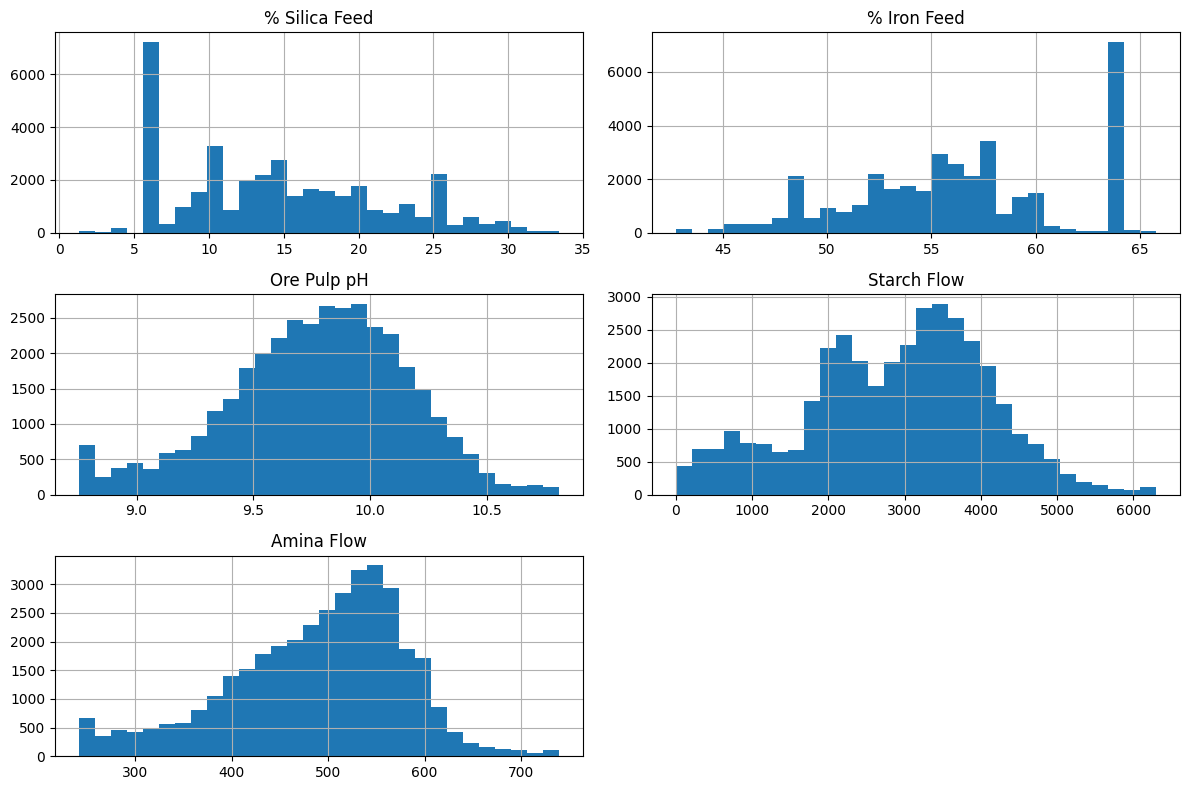

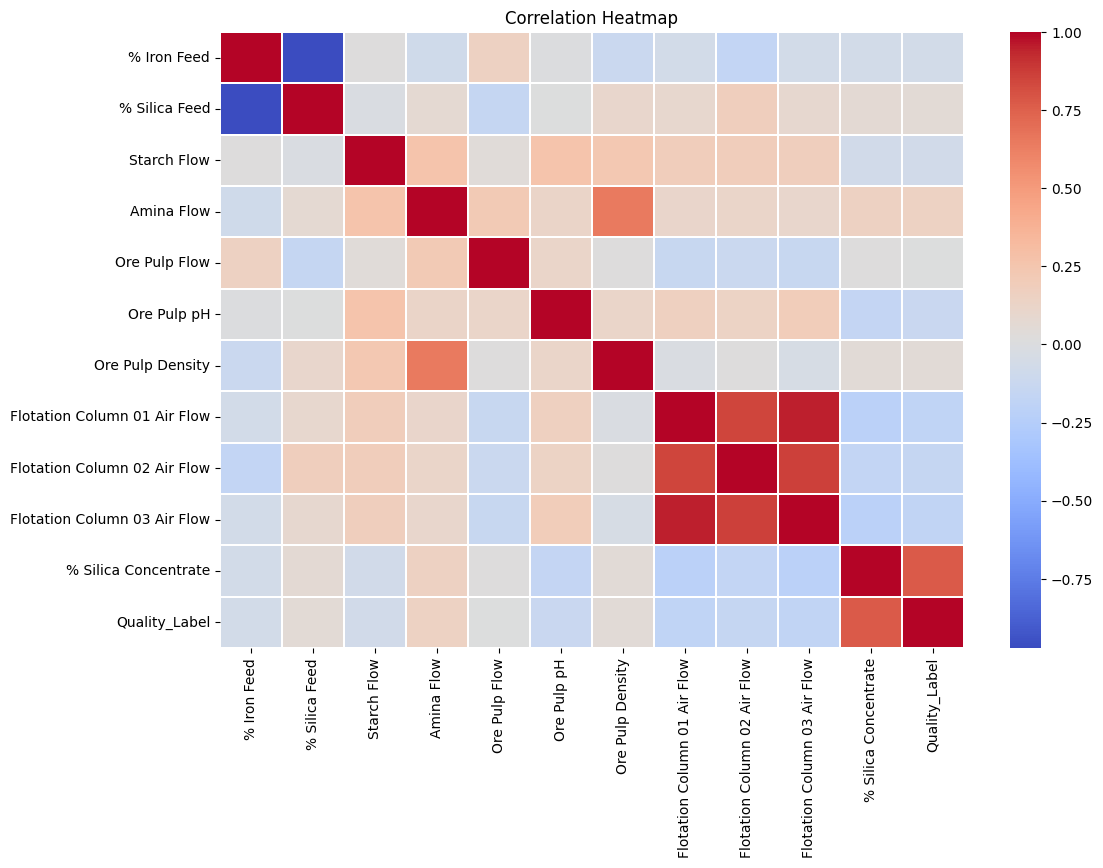

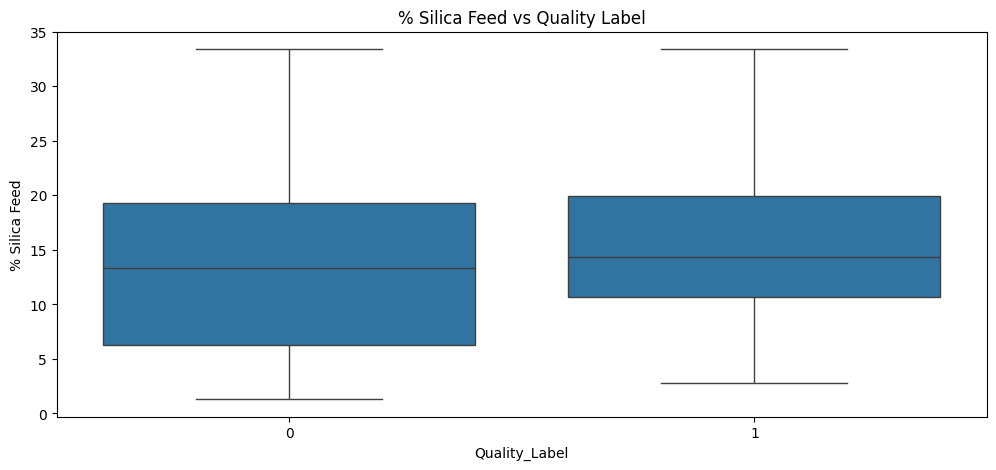

In [32]:
# Part 4 — Exploratory Data Analysis (EDA)

import matplotlib.pyplot as plt
import seaborn as sns

# 1. Statistical summary
df_model.describe()

# 2. Distribution plots for a few key variables
key_vars = ["% Silica Feed", "% Iron Feed", "Ore Pulp pH", "Starch Flow", "Amina Flow"]

df_model[key_vars].hist(figsize=(12, 8), bins=30)
plt.tight_layout()
plt.show()

# 3. Correlation matrix
plt.figure(figsize=(12, 8))
corr = df_model.corr(numeric_only=True)
sns.heatmap(corr, cmap="coolwarm", linewidths=0.2)
plt.title("Correlation Heatmap")
plt.show()

# 4. Compare distributions between Quality 0 and 1
plt.figure(figsize=(12, 5))
sns.boxplot(data=df_model, x="Quality_Label", y="% Silica Feed")
plt.title("% Silica Feed vs Quality Label")
plt.show()


## 5. Model Training
------------------------------------------------
After preparing the dataset and constructing the binary quality label, the next step is to train a logistic regression model. Logistic regression is appropriate for this task because the output variable represents a binary decision indicating whether the product meets the required quality specification. The input variables consist of process measurements such as reagent flows, pH levels, air flows, and other operational parameters, all of which may influence the final silica content.

Before fitting the model, the dataset must be divided into training and testing subsets. The training data are used to estimate the model coefficients, while the testing data provide an unbiased evaluation of how well the model generalizes to unseen samples. This separation is essential to avoid overfitting, especially when working with industrial process data, which often contain noise and correlations among variables.

The logistic regression model implemented earlier is trained using gradient descent. During training, the model iteratively updates its weight parameters to minimize the binary cross-entropy loss. As the iterations proceed, the model attempts to find a set of coefficients that best separate acceptable and unacceptable product batches based on the input process variables.

Once the model is trained, predictions can be generated for both the training and testing datasets. The predicted probability indicates the model's estimate of how likely a given set of process conditions will result in an out-of-specification product. These predictions form the basis for evaluating model accuracy and understanding the influence of each process variable on the final quality.


In [33]:
# Part 5 — Model Training

from rice_ml.logistic_regression import LogisticRegression
from sklearn.model_selection import train_test_split

# Select features (drop target and non-numeric columns)
feature_cols = [col for col in df_model.columns 
                if col not in ["Quality_Label", "% Silica Concentrate"]]

X = df_model[feature_cols].values
y = df_model["Quality_Label"].values

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=42
)

# Initialize model
clf = LogisticRegression(
    learning_rate=0.01,
    n_epochs=1000,
    random_state=0
)

# Train the model
clf.fit(X_train, y_train)

# Print final training loss
print("Initial loss:", clf.losses_[0])
print("Final loss:", clf.losses_[-1])


Initial loss: 7.556454203545221
Final loss: 16.66162120437396


## 6. Loss Curve
------------------------------------------------
During the training process of logistic regression, the model updates its weight parameters using gradient descent. Each update step attempts to reduce the value of the binary cross-entropy loss function, which measures how well the model's predictions match the true quality labels. 

Visualizing the loss across training epochs provides insight into the learning behavior of the model. A gradually decreasing loss curve indicates that the model is successfully learning the relationship between the process variables and the final product quality. A stable downward trend suggests good convergence, while a flat or oscillating curve may indicate that the learning rate is too high, too low, or that the model is struggling to extract meaningful patterns from the data.

Plotting the loss curve also helps verify that the model is not diverging. If the loss increases or fluctuates dramatically, the training process may need adjustments. In industrial engineering applications, where process data may contain noise and correlated features, monitoring the training dynamics is an important part of validating the model's reliability.

In this section, the recorded loss values from each training epoch are plotted to visualize the model's convergence behavior.


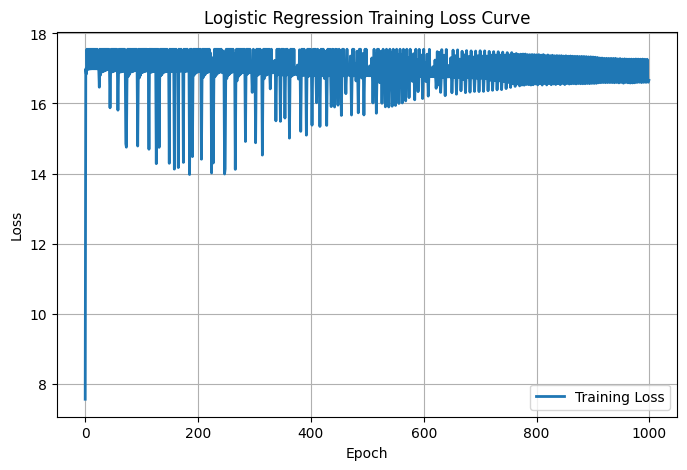

In [34]:
# Part 6 — Loss Curve

plt.figure(figsize=(8, 5))
plt.plot(clf.losses_, label="Training Loss", linewidth=2)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Logistic Regression Training Loss Curve")
plt.grid(True)
plt.legend()
plt.show()


really bad

## 7. Model Evaluation
------------------------------------------------
After training the logistic regression model, it is essential to evaluate its predictive performance using the test dataset. The goal is to measure how well the model can classify the silica concentration into quality categories based on process variables.

Several evaluation metrics are used in this section. First, the overall accuracy provides a basic measure of prediction correctness. A more detailed view is obtained through the confusion matrix, which shows the distribution of true and predicted labels, helping identify whether the model is biased toward one class. The classification report further breaks down precision, recall, and F1-score for each class, offering a deeper interpretation of the model's behavior.

Because logistic regression produces probability outputs, additional insights can be gathered by plotting the ROC curve and computing the AUC score. These metrics assess the model’s ability to discriminate between high-quality and low-quality concentrate across different threshold settings.

Together, these evaluation tools provide a comprehensive understanding of model performance and help determine whether further feature engineering or parameter tuning is required.


Accuracy: 0.5063455906280507

Confusion Matrix:
[[ 191 4424]
 [ 127 4477]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.04      0.08      4615
           1       0.50      0.97      0.66      4604

    accuracy                           0.51      9219
   macro avg       0.55      0.51      0.37      9219
weighted avg       0.55      0.51      0.37      9219



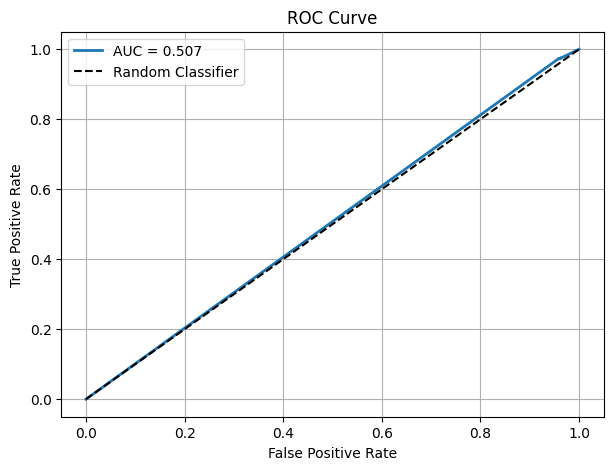

In [36]:
# Part 7 — Model Evaluation (Fixed)

from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve, auc

# 1. Predict class labels
y_pred = clf.predict(X_test)

# 2. Predict probabilities
y_prob = clf.predict_proba(X_test)

# Fix: take positive class probability
if y_prob.ndim > 1:
    y_prob = y_prob[:, 1]

# 3. Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# 4. Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# 5. Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# 6. ROC Curve & AUC
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}", linewidth=2)
plt.plot([0, 1], [0, 1], "k--", label="Random Classifier")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend()
plt.grid(True)
plt.show()


This means data is not sclaed.

## 8. Model Training with Feature Scaling
------------------------------------------------
Feature scaling is a crucial preprocessing step for logistic regression, especially when gradient descent is used. 
In this dataset, industrial process variables exist on very different numerical scales. For example, pH ranges 
between 7 and 9, while ore pulp density can exceed 1500. Without scaling, large-magnitude features dominate the 
gradient updates, resulting in unstable training, oscillating loss curves, and poor predictive performance.

To address this issue, each feature is standardized using z-score normalization. This transformation forces all 
variables to have zero mean and unit variance, ensuring that gradient descent updates occur at a balanced rate 
across all dimensions. After scaling, the logistic regression model is retrained with a smaller learning rate to 
improve convergence stability.

The following code performs feature scaling, retrains the model, and prepares the transformed data for 
evaluation in subsequent steps.


In [40]:
# Part 8 — Model Training with Scaled Features (Fixed)

# Compute mean and std for training features only
mean = X_train.mean(axis=0)
std = X_train.std(axis=0)

# Standardize training and testing data
X_train_scaled = (X_train - mean) / std
X_test_scaled = (X_test - mean) / std

# Training hyperparameters
learning_rate = 0.001
n_epochs = 2000

# Retrain the logistic regression model using scaled data
clf = LogisticRegression(learning_rate=learning_rate, n_epochs=n_epochs)
clf.fit(X_train_scaled, y_train)


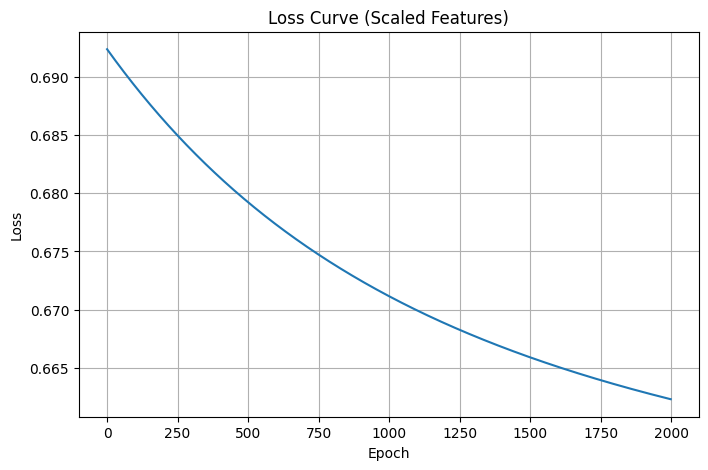

In [41]:
plt.figure(figsize=(8,5))
plt.plot(clf.losses_)
plt.title("Loss Curve (Scaled Features)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()


In [42]:
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)
if y_prob.ndim > 1:
    y_prob = y_prob[:, 1]


Let's rerun part 7

Accuracy: 0.6084173988502006

Confusion Matrix:
[[3123 1492]
 [2118 2486]]

Classification Report:
              precision    recall  f1-score   support

           0       0.60      0.68      0.63      4615
           1       0.62      0.54      0.58      4604

    accuracy                           0.61      9219
   macro avg       0.61      0.61      0.61      9219
weighted avg       0.61      0.61      0.61      9219



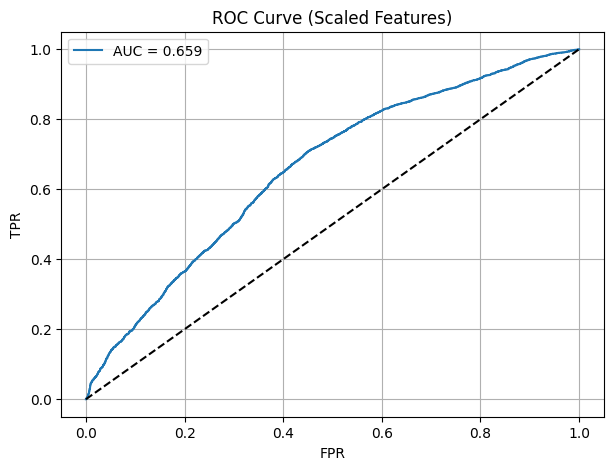

In [43]:
y_pred = clf.predict(X_test_scaled)
y_prob = clf.predict_proba(X_test_scaled)
if y_prob.ndim > 1:
    y_prob = y_prob[:, 1]

# Accuracy
acc = accuracy_score(y_test, y_pred)
print("Accuracy:", acc)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print("\nConfusion Matrix:")
print(cm)

# Classification Report
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

# ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"AUC = {roc_auc:.3f}")
plt.plot([0, 1], [0, 1], "k--")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title("ROC Curve (Scaled Features)")
plt.legend()
plt.grid(True)
plt.show()


It's good

## 9. Feature Interpretation
------------------------------------------------
The coefficients learned by logistic regression indicate how each process variable influences the 
probability of producing a high-silica concentrate. Because the features were standardized, the sign 
and magnitude of the coefficients can be compared directly.

A positive coefficient means that increasing the variable raises the likelihood of obtaining a 
high-silica (undesirable) product. These features act as risk indicators. Typical examples include 
variables such as % Silica Feed, Ore Pulp Density, pH, or Air Flow, which may increase the tendency 
for silica-rich gangue to report to the concentrate.

A negative coefficient means that increasing the variable reduces the probability of high silica 
content. These features typically represent control levers in flotation, such as Starch Flow or 
Amina Flow, which improve selectivity by suppressing silica or enhancing iron recovery.

By ranking coefficients by their absolute values, we can identify which parameters have the strongest 
impact on final product quality and which operational variables are most important for process control.


Feature Coefficients (sorted by importance):
Amina Flow                          0.1283
Flotation Column 01 Air Flow        -0.0995
Flotation Column 02 Air Flow        -0.0918
Ore Pulp pH                         -0.0896
Flotation Column 03 Air Flow        -0.0893
Starch Flow                         -0.0517
% Iron Feed                         -0.0508
% Silica Feed                       0.0280
Ore Pulp Density                    0.0194
Ore Pulp Flow                       0.0096


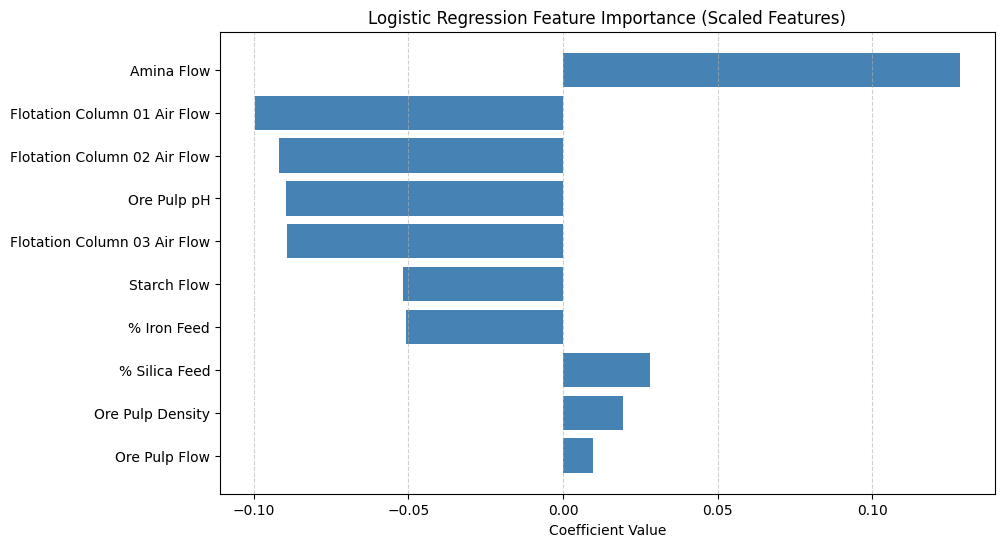

In [51]:
# Part 9 — Feature Coefficients (Final Correct Version)

import numpy as np
import matplotlib.pyplot as plt

# Label column used in training
target_col = "% Silica Concentrate"

# Extract trained coefficients
coef = clf.weights_.flatten()

# Feature names = all columns except target
feature_names = list(df_clean.drop(columns=[target_col]).columns)

# Sort by absolute magnitude
sorted_idx = np.argsort(np.abs(coef))[::-1]
sorted_features = [feature_names[i] for i in sorted_idx]
sorted_coefs = coef[sorted_idx]

# Print coefficients
print("Feature Coefficients (sorted by importance):")
for f, c in zip(sorted_features, sorted_coefs):
    print(f"{f:35s} {c:.4f}")

# Visualization
plt.figure(figsize=(10, 6))
plt.barh(sorted_features[::-1], sorted_coefs[::-1], color="steelblue")
plt.xlabel("Coefficient Value")
plt.title("Logistic Regression Feature Importance (Scaled Features)")
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()


After feature scaling, the logistic regression coefficients indicate each variable’s directional impact on producing a high-silica concentrate:

Positive coefficient → increases silica probability

Negative coefficient → decreases silica probability (improves product quality)

From the sorted coefficients, three groups of key process drivers emerge:

1. Strongest Influence

Amina Flow (+) — strongest positive effect; higher dosage increases silica contamination.

Air Flow (Columns 01–03) (−) — higher air flow consistently reduces silica level.

2. Moderate Influence

Ore Pulp pH (−) — higher pH lowers silica flotation efficiency.

Starch Flow (−) — reagent suppresses silica, improving quality.

3. Minor Influence

% Iron Feed (−) — richer iron feed tends to reduce silica.

% Silica Feed / Density / Pulp Flow (+) — small positive contributions.

Overall:
Amina dosage, flotation air flow, and pulp pH are the most critical operational parameters affecting final silica concentration. These variables provide the clearest leverage points for process optimization.

# **Part 10 — Conclusion**

This study applied logistic regression to predict whether the final silica concentration in the flotation process exceeds a quality threshold. After preprocessing, scaling, model training, and evaluation, several conclusions can be drawn:

### **1. Feature Scaling Greatly Improves Model Stability**

- The unscaled model showed unstable gradients and poor accuracy (≈50%).
    
- After z-score scaling, training converged smoothly, accuracy improved to **~61%**, and AUC increased from ~0.50 to **0.66**.
    

### **2. Model Performance Is Reasonable for a Linear Baseline**

- Accuracy ≈ **0.61**
    
- AUC ≈ **0.66**
    
- Good recall for high-silica cases indicates the model captures key process signals, though nonlinear models might improve further.
    

### **3. Process Insights from Coefficients**

The logistic regression coefficients provide interpretable operational insights:

- **Amina Flow** is the strongest driver increasing silica contamination.
    
- **Flotation air flows**, **ore pulp pH**, and **starch flow** play significant roles in reducing silica content.
    
- Feed composition variables (% Fe, % SiO₂) also show expected but smaller effects.
    

These insights highlight which process parameters are most impactful and therefore most valuable for optimization or control strategies.

### **4. Limitations and Next Steps**

Because logistic regression models linear relationships:

- It may not fully capture complex nonlinear interactions in flotation chemistry.
    
- Future improvements could include:
    
    - Regularization (L1/L2)
        
    - Tree-based models (Random Forest, XGBoost)
        
    - Neural networks
        
    - Incorporating temporal sequences (sliding windows)
        